In [1]:
import matplotlib.pyplot as plt 
import numpy             as np
import torch
import json
import os
import sys

from torch_geometric.data   import Batch
from torch_geometric.loader import DataLoader
from libraries.model        import nGCNN, eGCNN, diffusion_step, get_graph_losses, add_features_to_graph, predict_noise, diffuse, denoise, EarlyStopping
from libraries.dataset      import standardize_dataset, get_datasets

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
device

device(type='cuda')

In [3]:
# Based on adding and removing noise to graphs
# The models is able to learn hidden patterns
# It can be conditionally trained with respect to some target property
# Although denoising includes noise, I think it is better not to add it when training

In [4]:
# Define name of data folder where reference dataset are contained
# It shall be consistent with data_folder and data will be moved to models folder
data_name = 'GM_PT_EPA-sphere-images'

# Define folder in which data is stored
data_folder = f'data/{data_name}'

# The folder is named as target_folder_vi (eg, target_folder_v0)
general_folder = f'models/{data_name}'
if not os.path.exists(general_folder):
    # Generate new folder
    os.system(f'mkdir {general_folder}')

# Each new run generates a new folder, with different generations and training most likely (as data might vary as well)
i = 0
while True:
    target_folder = f'{general_folder}/GM_v{i}'
    if not os.path.exists(target_folder):
        # Copy all data
        os.system(f'cp -r {data_folder} {target_folder}')
        break
    i += 1

edge_model_name = f'{target_folder}/edge_model.pt'
node_model_name = f'{target_folder}/node_model.pt'
target_folder

'models/GM_PT_EPA-sphere-images/GM_v8'

In [5]:
# Machine-learning parameters
n_epochs      = 2000
batch_size    = 32
learning_rate = 0.0001
patience      = n_epochs
delta         = 0.2
check_labels  = False  # Whether to train-test split attending to labels or not

# Number of diffusing and denoising steps
n_t_steps = 1000

# Amount of noise for the generative process
sigma = 0  # Zero for training purposes

# Decay of parameter alpha
noise_contribution = 0.05
alpha_decay = 0.5 * (1 - noise_contribution**2)

# Dropouts for node and edge models (independent of each other)
dropout_node = 0.1
dropout_edge = 0.1

# Create and save as a dictionary
model_parameters = {
    'data_folder':        data_folder,
    'n_epochs':           n_epochs,
    'batch_size':         batch_size,
    'learning_rate':      learning_rate,
    'patience':           patience,
    'delta':              delta,
    'check_labels':       check_labels,
    'n_t_steps':          n_t_steps,
    'sigma':              sigma,
    'noise_contribution': noise_contribution,
    'dropout_node':       dropout_node,
    'dropout_edge':       dropout_edge
}

# Write the dictionary to the file in JSON format
with open(f'{target_folder}/model_parameters.json', 'w') as json_file:
    json.dump(model_parameters, json_file)

# Load of graph database for training

Load the dataset, already standardized.

In [6]:
labels_name                 = f'{target_folder}/labels.pt'
dataset_name                = f'{target_folder}/dataset.pt'
dataset_name_std            = f'{target_folder}/standardized_dataset.pt'
dataset_parameters_name_std = f'{target_folder}/standardized_parameters.json'  # Parameters for rescaling the predictions

if os.path.exists(dataset_name_std) and os.path.exists(dataset_parameters_name_std) and os.path.exists(labels_name):
    # Load the standardized dataset, with corresponding labels and parameters
    dataset = torch.load(dataset_name_std)
    labels  = torch.load(labels_name)
    
    # Load the data from the JSON file
    with open(dataset_parameters_name_std, 'r') as json_file:
        numpy_dict = json.load(json_file)

    # Convert NumPy arrays back to PyTorch tensors
    dataset_parameters = {}
    for key, value in numpy_dict.items():
        try:
            dataset_parameters[key] = torch.tensor(value)
        except:
            dataset_parameters[key] = value

elif os.path.exists(dataset_name) and os.path.exists(labels_name):
    # Load the raw dataset, with corresponding labels, and standardize it
    dataset = torch.load(dataset_name)
    labels  = torch.load(labels_name)
    
    # Standardize dataset
    dataset, dataset_parameters = standardize_dataset(dataset)
    
    # Save standardized dataset
    torch.save(dataset, dataset_name_std)
    
    # Convert torch tensors to numpy arrays
    numpy_dict = {key: value.cpu().numpy().tolist() for key, value in dataset_parameters.items()}

    # Dump the dictionary with numpy arrays to a JSON file
    with open(dataset_parameters_name_std, 'w') as json_file:
        json.dump(numpy_dict, json_file)

else:
    sys.exit('Error: the database is not available')

# Defining target factor
target_factor = dataset_parameters['target_std'] / dataset_parameters['scale']

Split in train, validation and test sets.

In [7]:
train_ratio = 0.8
test_ratio  = 0.1

# Check if data has been already split, else do it randomly
path_to_train_labels = f'{target_folder}/train_labels.txt'
path_to_val_labels   = f'{target_folder}/validation_labels.txt'
path_to_test_labels  = f'{target_folder}/test_labels.txt'

# Copy labels
material_labels = labels.copy()

if os.path.exists(path_to_train_labels) and os.path.exists(path_to_val_labels) and os.path.exists(path_to_test_labels):
    # Read labels splitting (which are strings)
    train_labels = np.genfromtxt(path_to_train_labels, dtype='str').tolist()
    val_labels   = np.genfromtxt(path_to_val_labels,   dtype='str').tolist()
    test_labels  = np.genfromtxt(path_to_test_labels,  dtype='str').tolist()
else:
    if check_labels:
        # Splitting into train-test sets considering that Fvs from the same materials must be in the same dataset
        material_labels = [label.split()[0] for label in material_labels]
        
        # Define unique labels
        unique_labels = np.unique(material_labels)
    else:
        # Completely randomly splitting
        # Copy material_labels
        unique_labels = material_labels.copy()
    
    # Shuffle the list of unique labels
    np.random.shuffle(unique_labels)

    # Define the sizes of the train and test sets
    # Corresponds to the size wrt the number of unique materials in the dataset
    train_size = int(train_ratio * len(unique_labels))
    test_size  = int(test_ratio  * len(unique_labels))
    
    train_labels = unique_labels[:train_size]
    val_labels   = unique_labels[train_size:-test_size]
    test_labels  = unique_labels[-test_size:]

    # Save this splitting for transfer-learning approaches
    np.savetxt(path_to_train_labels, train_labels, fmt='%s')
    np.savetxt(path_to_val_labels,   val_labels,   fmt='%s')
    np.savetxt(path_to_test_labels,  test_labels,  fmt='%s')

# Use the computed indexes to generate train and test sets
# We iteratively check where labels equals a unique train/test labels and append the index to a list
train_dataset = get_datasets(train_labels, material_labels, dataset)
val_dataset   = get_datasets(val_labels,   material_labels, dataset)
test_dataset  = get_datasets(test_labels,  material_labels, dataset)

del dataset  # Free up CUDA memory

print(f'Number of training   graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of testing    graphs: {len(test_dataset)}')

Number of training   graphs: 1100
Number of validation graphs: 138
Number of testing    graphs: 137


In [8]:
for graph in train_dataset:
    graph.y = torch.tensor([graph.y], dtype=torch.float)

for graph in val_dataset:
    graph.y = torch.tensor([graph.y], dtype=torch.float)

for graph in test_dataset:
    graph.y = torch.tensor([graph.y], dtype=torch.float)

for graph in train_dataset:
    #graph.x *= 100
    graph.edge_attr *= 100
    #graph.y *= 100

for graph in val_dataset:
    #graph.x *= 100
    graph.edge_attr *= 100
    #graph.y *= 100

for graph in test_dataset:
    #graph.x *= 100
    graph.edge_attr *= 100
    #graph.y *= 100

Define data loaders.

In [9]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=True, pin_memory=True)

# Determine number of node-level features in dataset
n_node_features = train_dataset[0].num_node_features

# Determine the number of graph-level features to be predicted
n_graph_features = len(train_dataset[0].y)

del train_dataset, val_dataset, test_dataset  # Free up CUDA memory

# Definition of the model

In [10]:
# Instantiate the models for nodes and edges, considering the t_step information; n_graph_features+1 for accounting for the time step
node_model = nGCNN(n_node_features, n_graph_features+1, dropout_node).to(device)
edge_model = eGCNN(n_node_features, n_graph_features+1, dropout_edge).to(device)

# Moving models to device
node_model = node_model.to(device)
edge_model = edge_model.to(device)

# Load previous model if available
#try:
#    # Load model state
#    node_model.load_state_dict(torch.load(node_model_name))
#    edge_model.load_state_dict(torch.load(edge_model_name))
#    
#    # Evaluate model state
#    node_model.eval()
#    edge_model.eval()
#except FileNotFoundError:
#    pass

print('\nNode GCNN:')
print(node_model)
print('\nEdge GCNN:')
print(edge_model)


Node GCNN:
nGCNN(
  (conv1): GraphConv(6, 32)
  (conv2): GraphConv(32, 4)
)

Edge GCNN:
eGCNN(
  (linear1): Linear(in_features=7, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=16, bias=True)
  (linear3): Linear(in_features=16, out_features=1, bias=True)
)


# Training of the model

In [11]:
# Decay of parameter alpha
alpha_decay = 0.5
t_step = n_t_steps
from libraries.model import get_alpha_t
torch.sqrt(1 - get_alpha_t(t_step, n_t_steps, alpha_decay))

tensor(0., device='cuda:0')

In [14]:
a, b = diffusion_step(g_batch_0[idx], t_step, n_t_steps, alpha_decay)
a.edge_attr, b.edge_attr

(tensor([-0.0669, -0.0669, -0.0643,  ..., -0.2031,  0.0758, -0.2031],
        device='cuda:0'),
 tensor([-0.3247,  1.2468, -0.3222,  ...,  1.3806,  0.1170,  1.8682],
        device='cuda:0'))

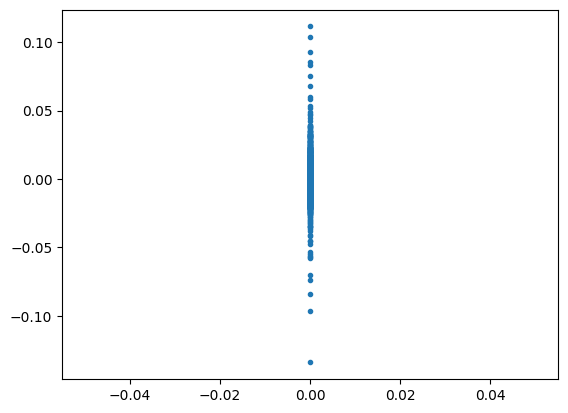

In [26]:
plt.plot(e_batch_t.edge_attr.detach().cpu().numpy().tolist(), pred_epsilon_t.edge_attr.detach().cpu().numpy().tolist(), '.')

(array([1.00000e+00, 1.00000e+00, 3.00000e+00, 1.20000e+01, 4.06000e+02,
        3.12667e+05, 2.26000e+02, 1.40000e+01, 4.00000e+00, 3.00000e+00]),
 array([-0.13411908, -0.10955996, -0.08500085, -0.06044173, -0.03588262,
        -0.0113235 ,  0.01323561,  0.03779473,  0.06235384,  0.08691296,
         0.11147207]),
 <BarContainer object of 10 artists>)

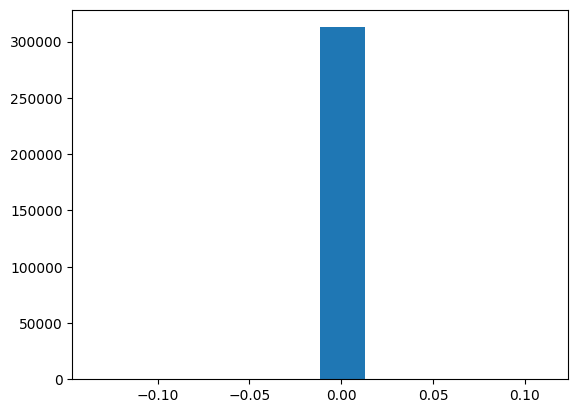

In [25]:
plt.hist(pred_epsilon_t.edge_attr.detach().cpu().numpy().tolist())

In [ ]:
            ground_truth['edge_attr'].append(e_batch_t.edge_attr.detach().cpu().numpy().tolist())
            ground_truth['atomic_mass'].append(e_batch_t.x[:, 0].detach().cpu().numpy().tolist())
            ground_truth['charge'].append(e_batch_t.x[:, 1].detach().cpu().numpy().tolist())
            ground_truth['electronegativity'].append(e_batch_t.x[:, 2].detach().cpu().numpy().tolist())
            ground_truth['ionization_energy'].append(e_batch_t.x[:, 3].detach().cpu().numpy().tolist())

            prediction['edge_attr'].append(pred_epsilon_t.edge_attr.detach().cpu().numpy().tolist())
            prediction['atomic_mass'].append(pred_epsilon_t.x[:, 0].detach().cpu().numpy().tolist())
            prediction['charge'].append(pred_epsilon_t.x[:, 1].detach().cpu().numpy().tolist())
            prediction['electronegativity'].append(pred_epsilon_t.x[:, 2].detach().cpu().numpy().tolist())
            prediction['ionization_energy'].append(pred_epsilon_t.x[:, 3].detach().cpu().numpy().tolist())

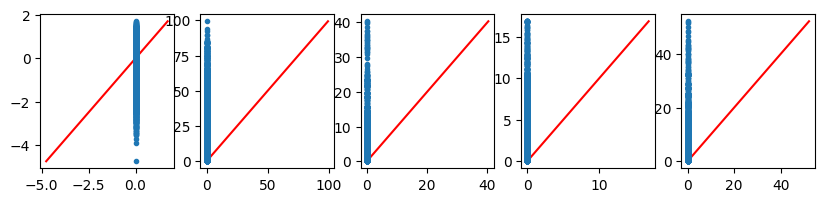

Epoch: 1, edge loss: 0.0007, node loss: 1.9467 0.0693 0.0268 0.1425


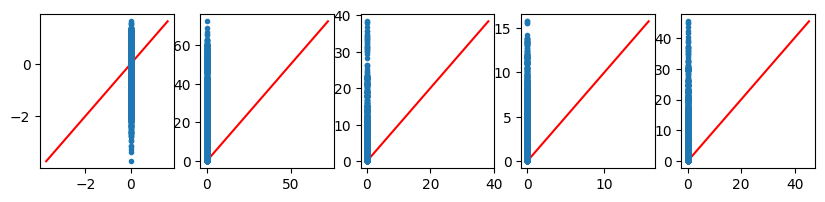

Epoch: 2, edge loss: 0.0005, node loss: 1.2408 0.0447 0.0145 0.0956


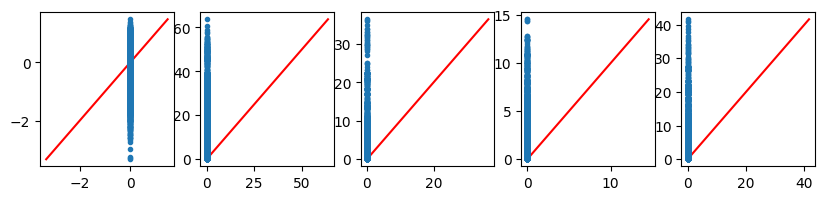

Epoch: 3, edge loss: 0.0004, node loss: 0.7406 0.0335 0.0109 0.0710


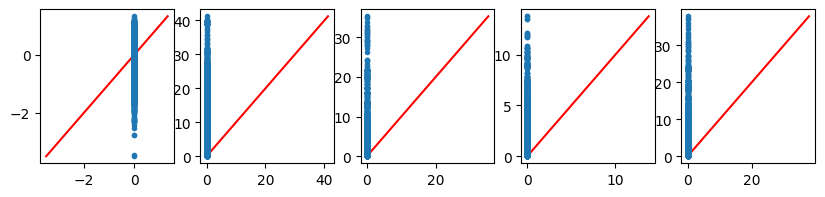

Epoch: 4, edge loss: 0.0003, node loss: 0.4362 0.0274 0.0083 0.0512


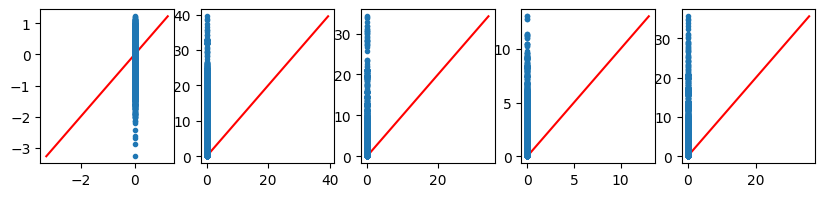

Epoch: 5, edge loss: 0.0003, node loss: 0.2700 0.0234 0.0067 0.0413


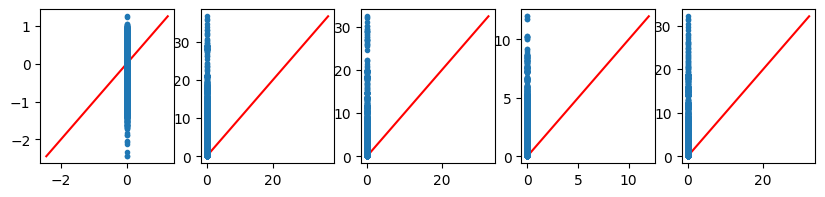

Epoch: 6, edge loss: 0.0002, node loss: 0.1630 0.0187 0.0058 0.0305


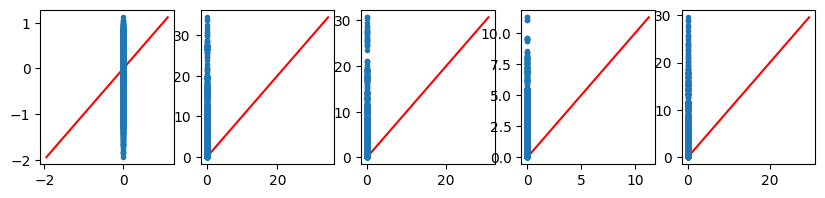

Epoch: 7, edge loss: 0.0002, node loss: 0.1051 0.0181 0.0048 0.0267


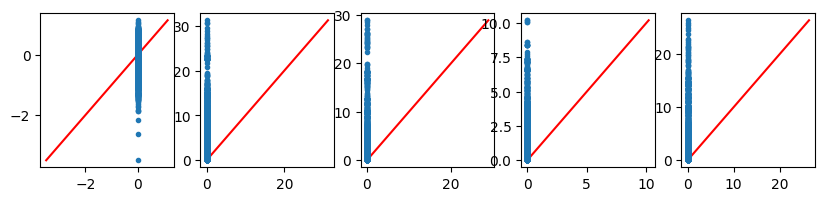

Epoch: 8, edge loss: 0.0002, node loss: 0.0690 0.0150 0.0038 0.0200


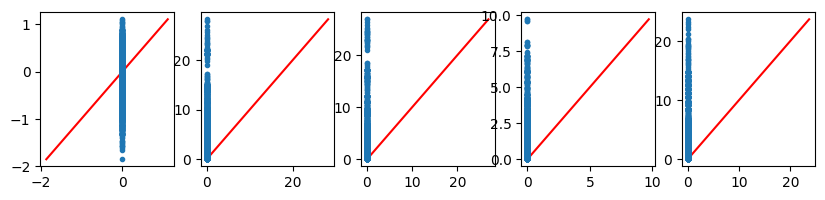

Epoch: 9, edge loss: 0.0001, node loss: 0.0543 0.0184 0.0037 0.0204


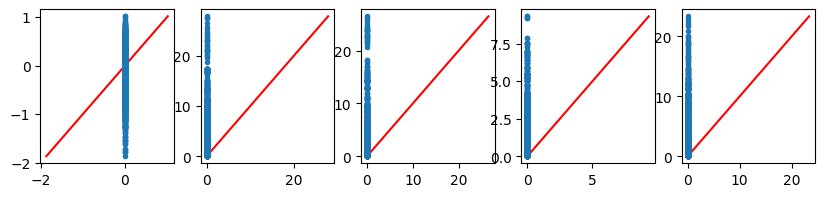

Epoch: 10, edge loss: 0.0001, node loss: 0.0344 0.0101 0.0030 0.0130


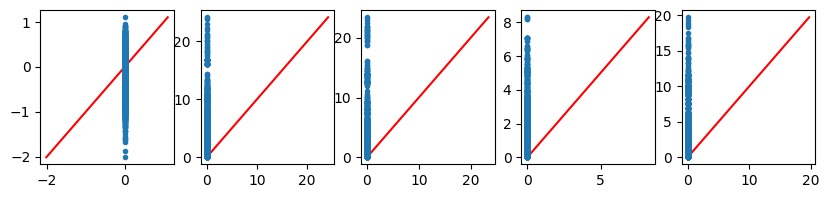

Epoch: 11, edge loss: 0.0001, node loss: 0.0255 0.0078 0.0026 0.0105


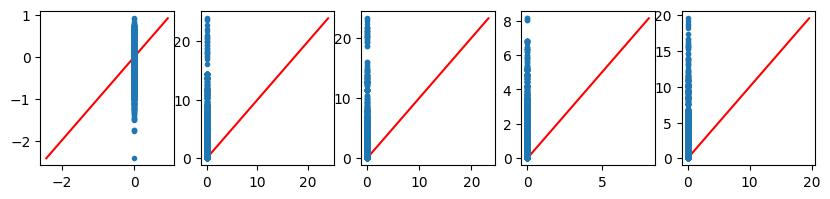

Epoch: 12, edge loss: 0.0001, node loss: 0.0207 0.0075 0.0024 0.0094


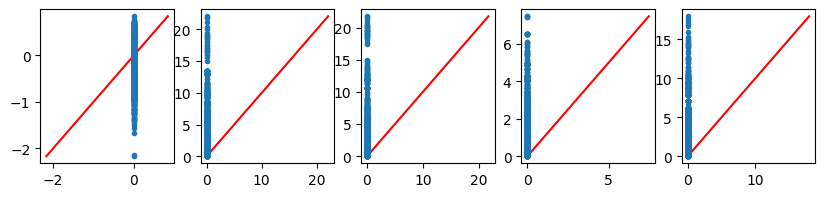

Epoch: 13, edge loss: 0.0001, node loss: 0.0167 0.0068 0.0022 0.0080


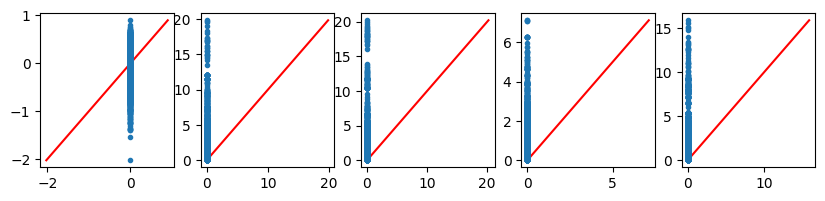

Epoch: 14, edge loss: 0.0001, node loss: 0.0129 0.0056 0.0019 0.0066


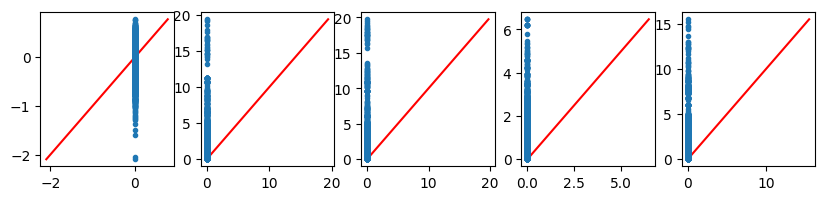

Epoch: 15, edge loss: 0.0001, node loss: 0.0106 0.0046 0.0018 0.0055


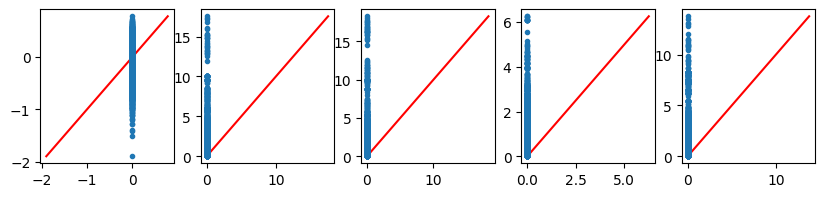

Epoch: 16, edge loss: 0.0001, node loss: 0.0091 0.0044 0.0016 0.0051


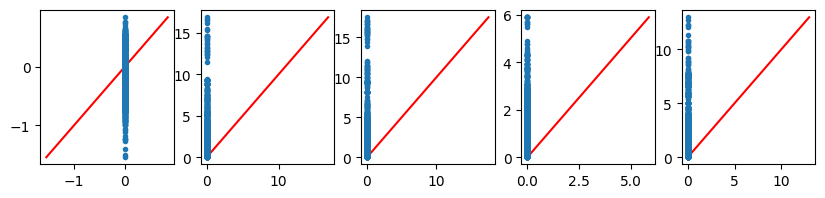

Epoch: 17, edge loss: 0.0001, node loss: 0.0078 0.0040 0.0015 0.0044


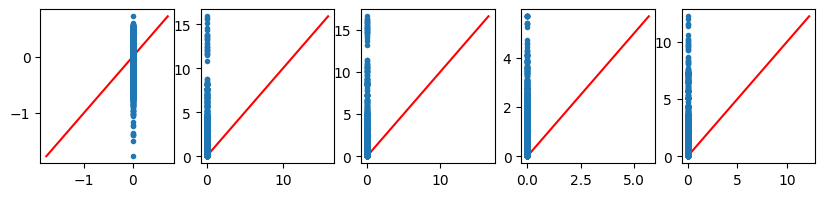

Epoch: 18, edge loss: 0.0001, node loss: 0.0066 0.0035 0.0013 0.0037


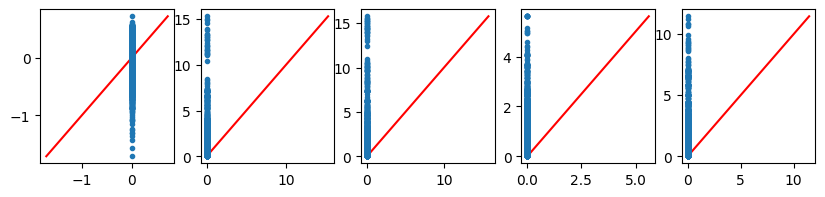

Epoch: 19, edge loss: 0.0001, node loss: 0.0063 0.0035 0.0012 0.0040


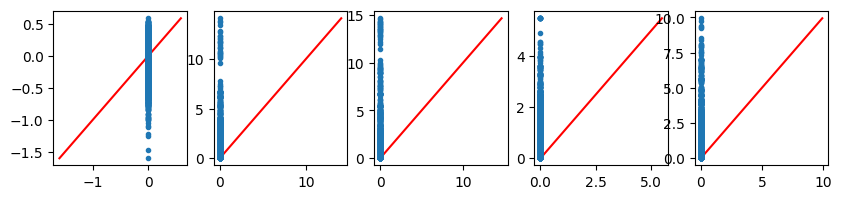

Epoch: 20, edge loss: 0.0001, node loss: 0.0051 0.0026 0.0012 0.0028


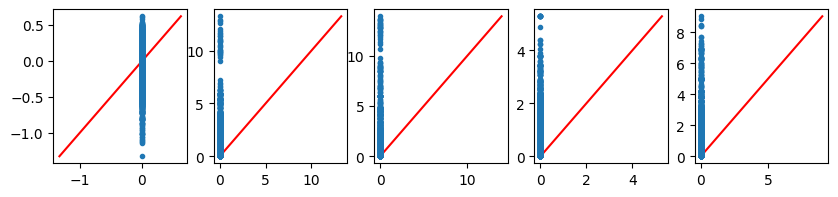

Epoch: 21, edge loss: 0.0000, node loss: 0.0044 0.0021 0.0011 0.0024


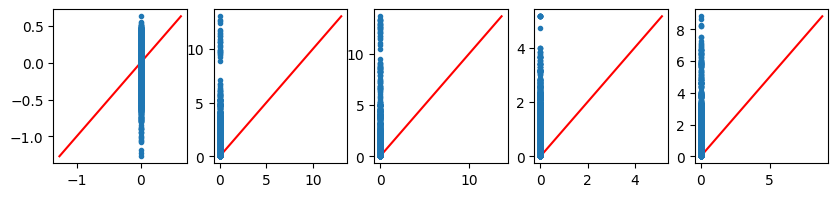

Epoch: 22, edge loss: 0.0000, node loss: 0.0043 0.0023 0.0012 0.0023


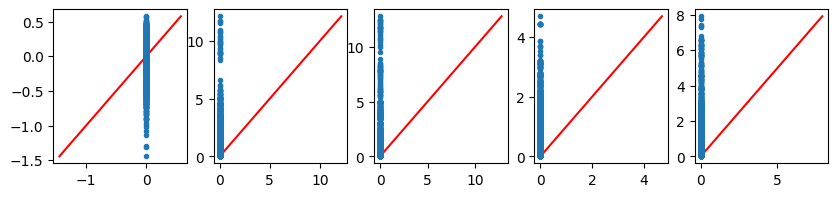

Epoch: 23, edge loss: 0.0000, node loss: 0.0038 0.0019 0.0009 0.0019


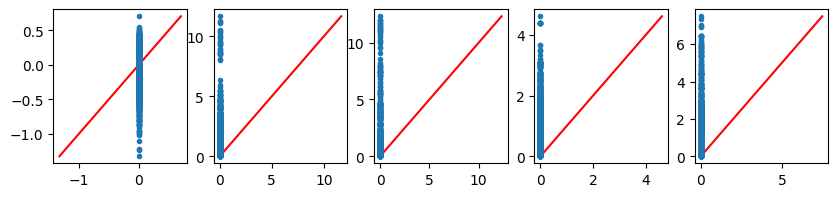

Epoch: 24, edge loss: 0.0000, node loss: 0.0035 0.0016 0.0009 0.0018


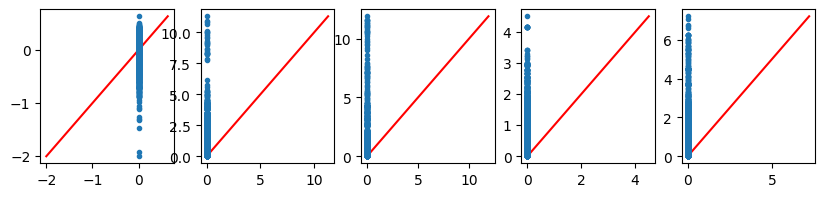

Epoch: 25, edge loss: 0.0000, node loss: 0.0032 0.0015 0.0008 0.0016


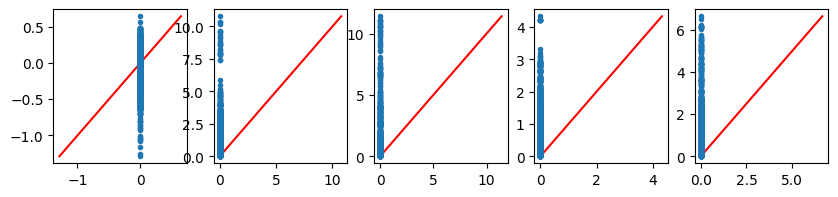

Epoch: 26, edge loss: 0.0000, node loss: 0.0030 0.0013 0.0008 0.0015


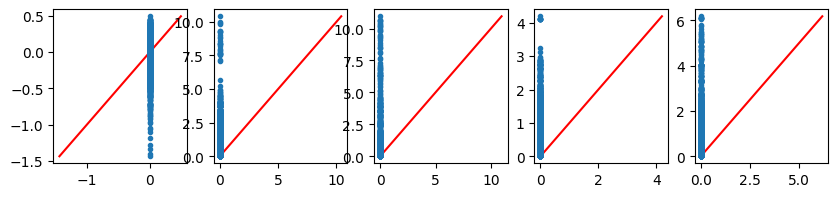

Epoch: 27, edge loss: 0.0000, node loss: 0.0028 0.0014 0.0007 0.0013


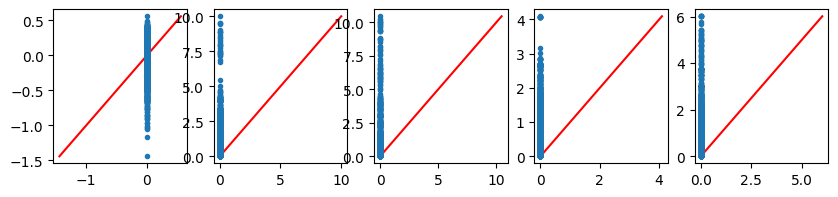

Epoch: 28, edge loss: 0.0000, node loss: 0.0026 0.0011 0.0007 0.0012


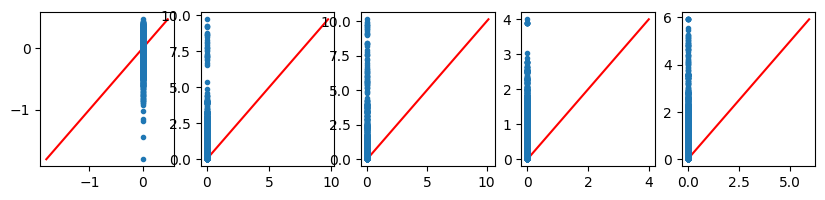

Epoch: 29, edge loss: 0.0000, node loss: 0.0024 0.0010 0.0007 0.0011


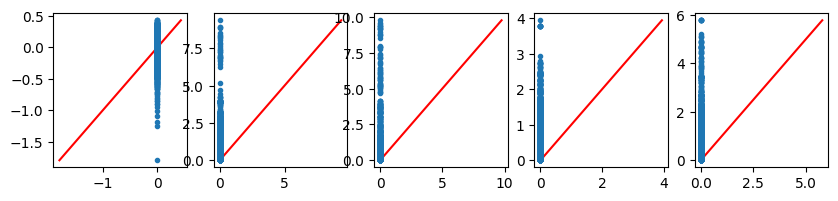

Epoch: 30, edge loss: 0.0000, node loss: 0.0023 0.0009 0.0006 0.0010


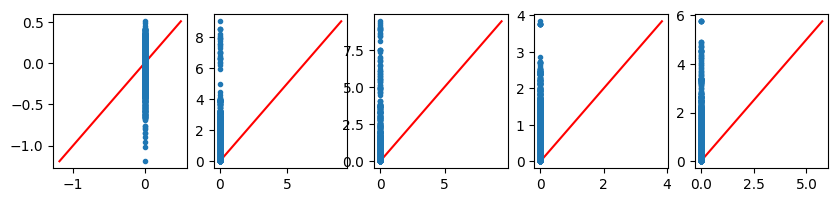

Epoch: 31, edge loss: 0.0000, node loss: 0.0022 0.0008 0.0006 0.0009


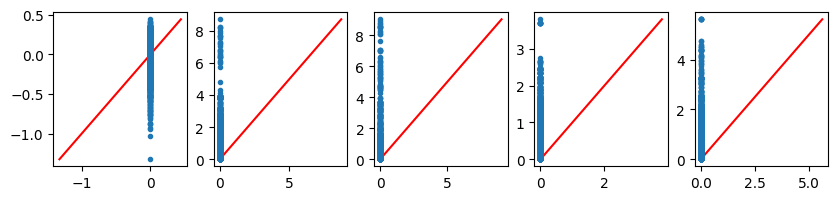

Epoch: 32, edge loss: 0.0000, node loss: 0.0021 0.0008 0.0005 0.0009


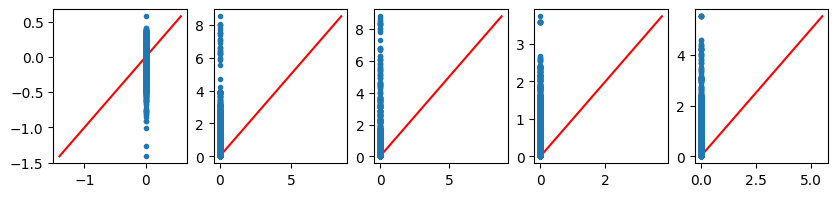

Epoch: 33, edge loss: 0.0000, node loss: 0.0020 0.0007 0.0005 0.0009


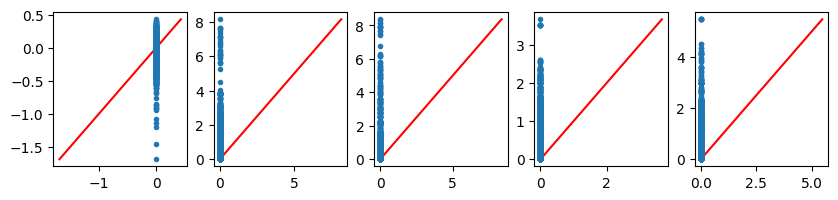

Epoch: 34, edge loss: 0.0000, node loss: 0.0019 0.0007 0.0005 0.0008


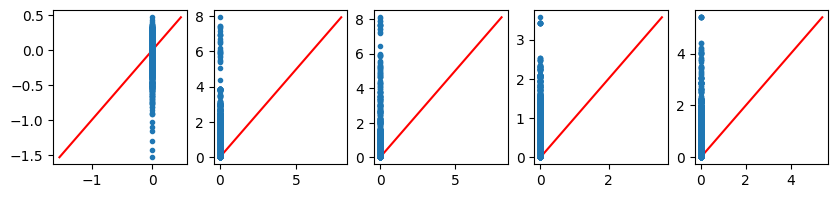

Epoch: 35, edge loss: 0.0000, node loss: 0.0018 0.0006 0.0005 0.0007


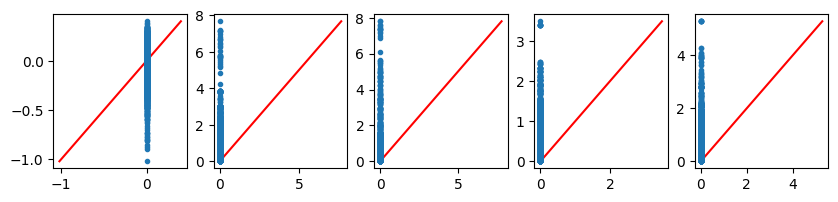

Epoch: 36, edge loss: 0.0000, node loss: 0.0018 0.0006 0.0006 0.0007


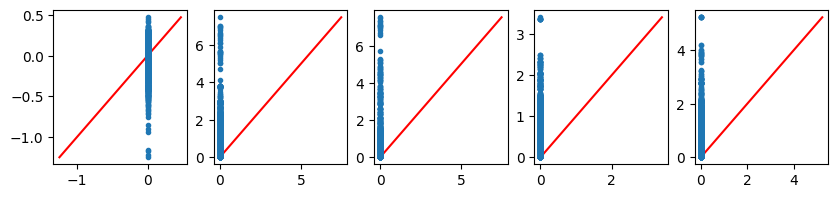

Epoch: 37, edge loss: 0.0000, node loss: 0.0016 0.0005 0.0004 0.0006


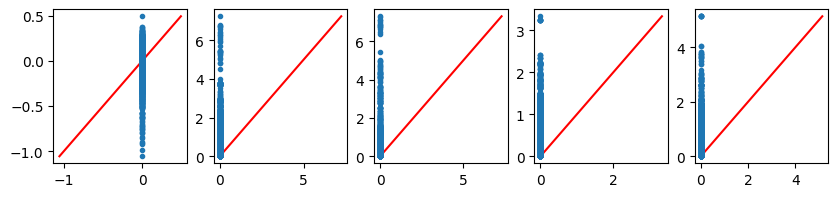

Epoch: 38, edge loss: 0.0000, node loss: 0.0016 0.0005 0.0004 0.0006


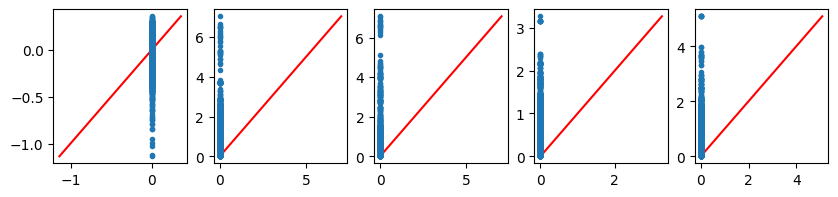

Epoch: 39, edge loss: 0.0000, node loss: 0.0015 0.0005 0.0004 0.0006


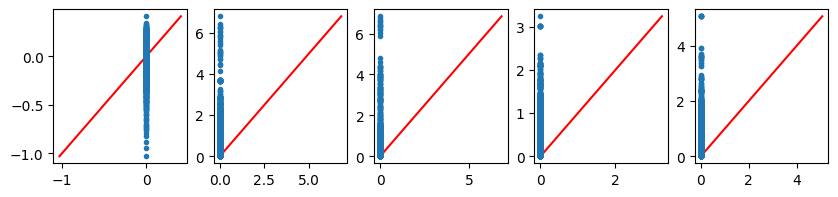

Epoch: 40, edge loss: 0.0000, node loss: 0.0015 0.0004 0.0003 0.0005


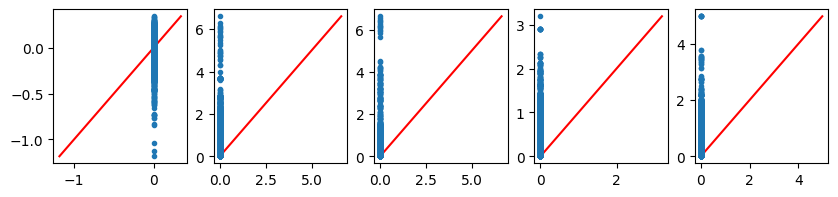

Epoch: 41, edge loss: 0.0000, node loss: 0.0015 0.0004 0.0003 0.0005


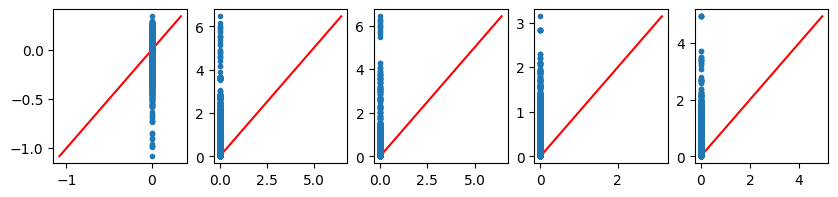

Epoch: 42, edge loss: 0.0000, node loss: 0.0014 0.0004 0.0003 0.0005


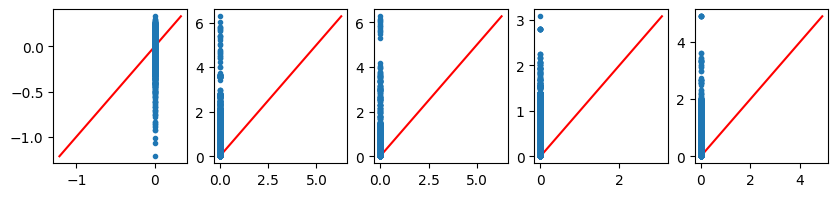

Epoch: 43, edge loss: 0.0000, node loss: 0.0013 0.0004 0.0003 0.0004


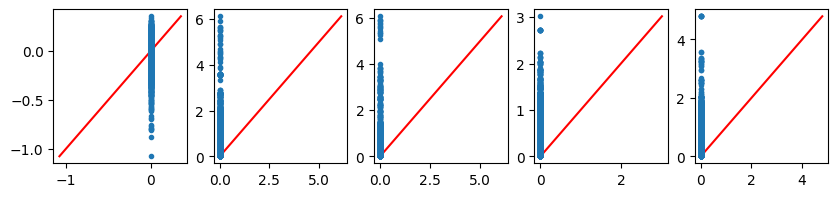

Epoch: 44, edge loss: 0.0000, node loss: 0.0013 0.0003 0.0003 0.0004


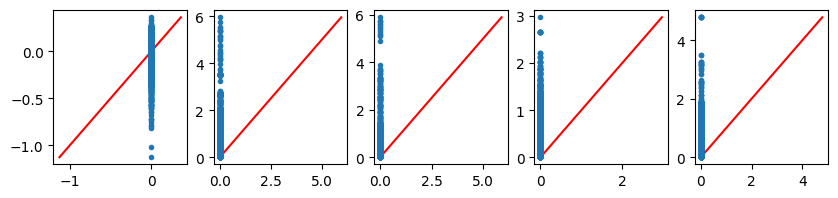

Epoch: 45, edge loss: 0.0000, node loss: 0.0013 0.0004 0.0003 0.0004


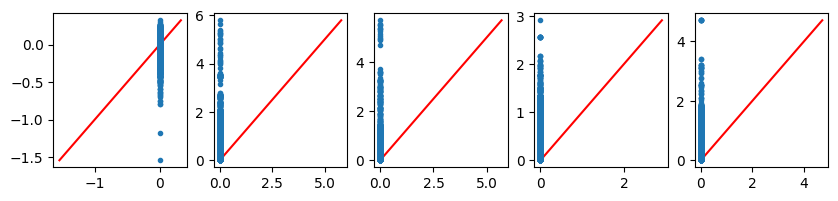

Epoch: 46, edge loss: 0.0000, node loss: 0.0012 0.0003 0.0003 0.0004


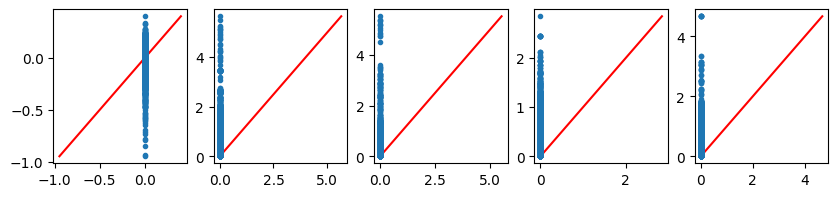

Epoch: 47, edge loss: 0.0000, node loss: 0.0012 0.0003 0.0003 0.0004


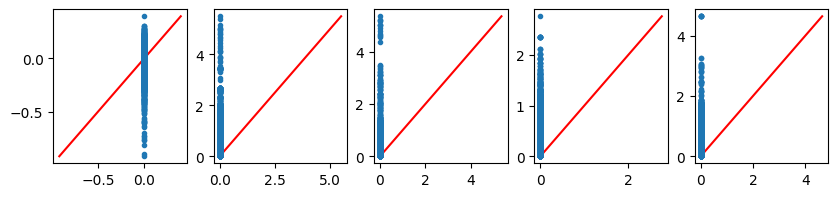

Epoch: 48, edge loss: 0.0000, node loss: 0.0011 0.0003 0.0002 0.0004


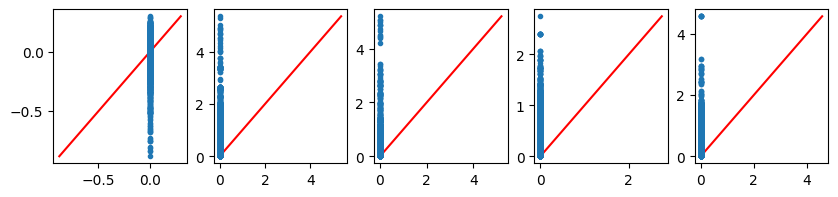

Epoch: 49, edge loss: 0.0000, node loss: 0.0011 0.0003 0.0002 0.0003


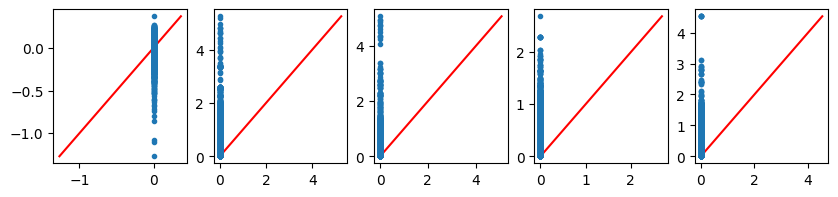

Epoch: 50, edge loss: 0.0000, node loss: 0.0011 0.0003 0.0002 0.0003


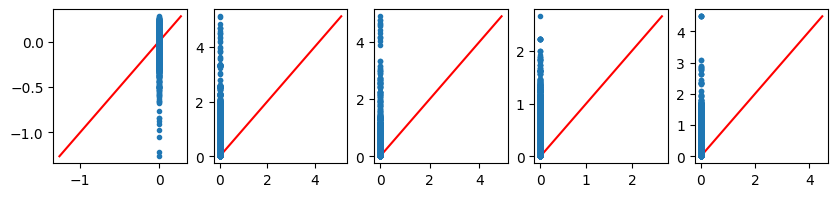

Epoch: 51, edge loss: 0.0000, node loss: 0.0011 0.0002 0.0002 0.0003


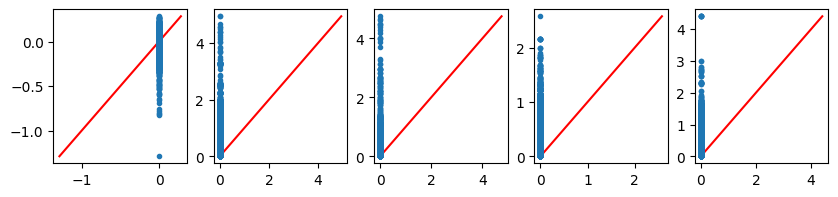

Epoch: 52, edge loss: 0.0000, node loss: 0.0010 0.0002 0.0002 0.0003


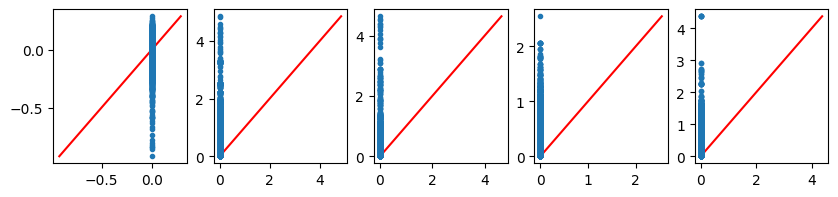

Epoch: 53, edge loss: 0.0000, node loss: 0.0010 0.0002 0.0002 0.0004


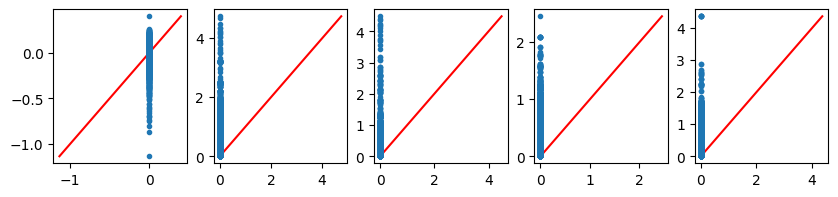

Epoch: 54, edge loss: 0.0000, node loss: 0.0010 0.0002 0.0002 0.0003


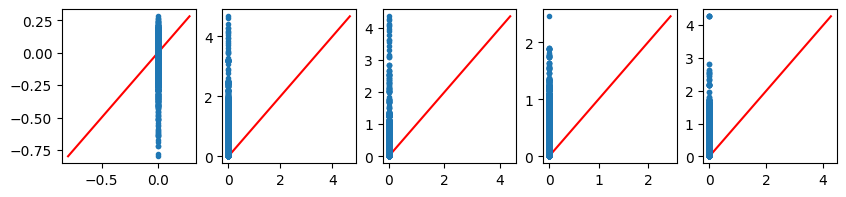

Epoch: 55, edge loss: 0.0000, node loss: 0.0009 0.0002 0.0002 0.0003


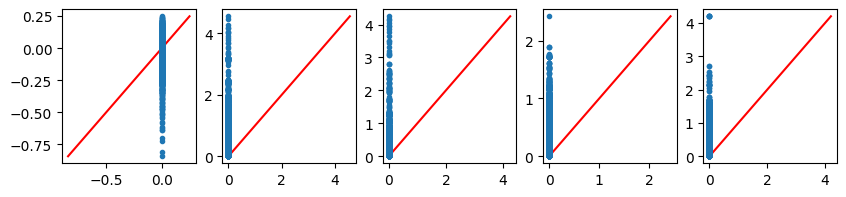

Epoch: 56, edge loss: 0.0000, node loss: 0.0009 0.0002 0.0002 0.0003


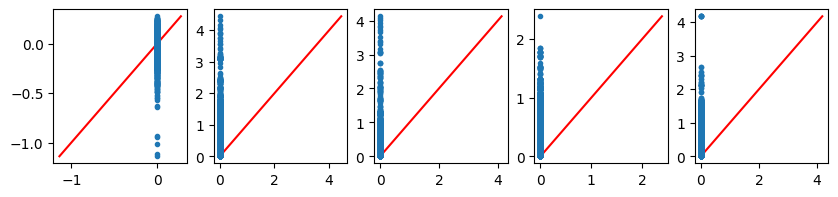

Epoch: 57, edge loss: 0.0000, node loss: 0.0009 0.0002 0.0002 0.0002


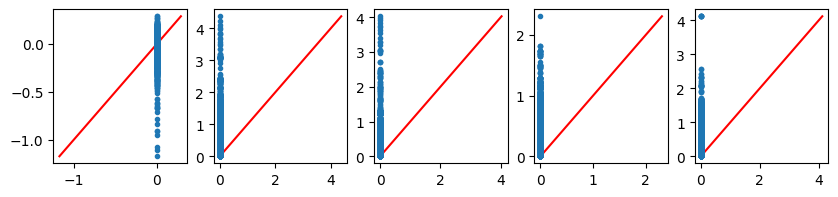

Epoch: 58, edge loss: 0.0000, node loss: 0.0009 0.0002 0.0002 0.0002


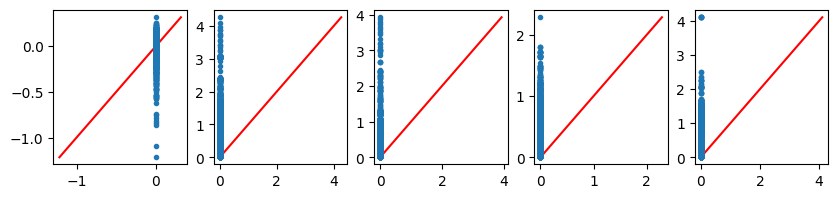

Epoch: 59, edge loss: 0.0000, node loss: 0.0008 0.0002 0.0001 0.0002


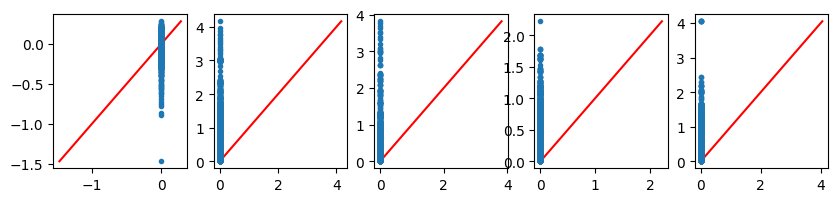

Epoch: 60, edge loss: 0.0000, node loss: 0.0009 0.0002 0.0001 0.0002


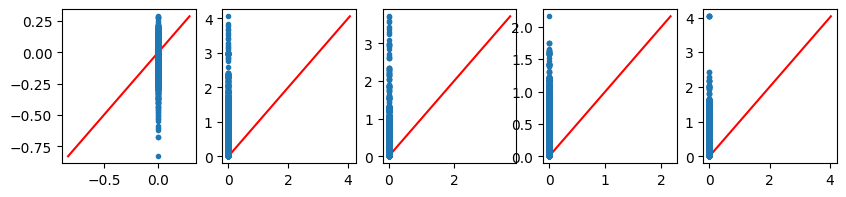

Epoch: 61, edge loss: 0.0000, node loss: 0.0008 0.0002 0.0001 0.0002


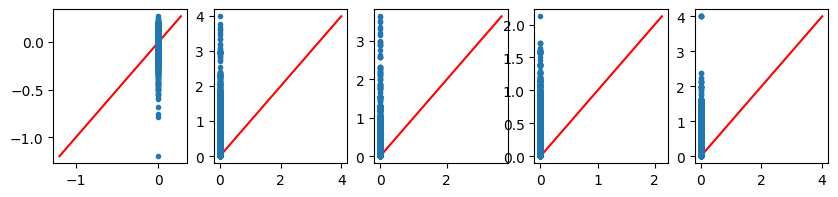

Epoch: 62, edge loss: 0.0000, node loss: 0.0008 0.0002 0.0001 0.0002


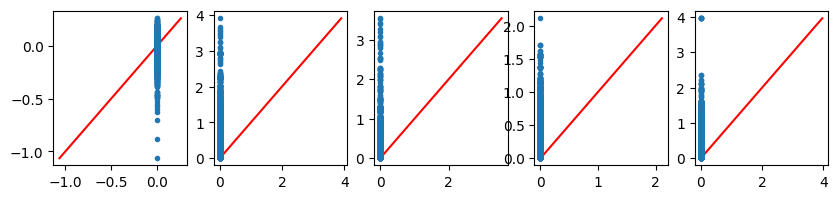

Epoch: 63, edge loss: 0.0000, node loss: 0.0008 0.0002 0.0001 0.0002


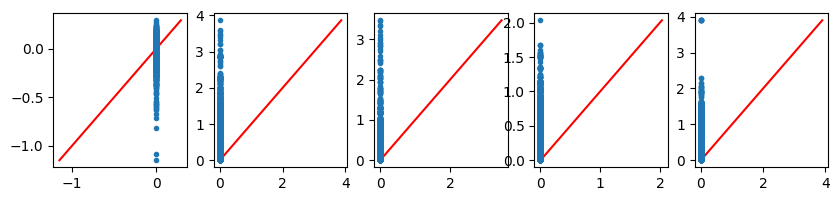

Epoch: 64, edge loss: 0.0000, node loss: 0.0007 0.0002 0.0001 0.0002


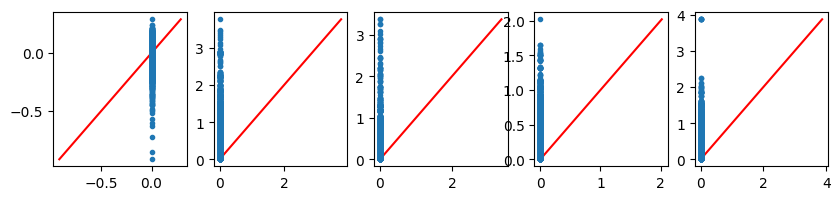

Epoch: 65, edge loss: 0.0000, node loss: 0.0007 0.0001 0.0001 0.0002


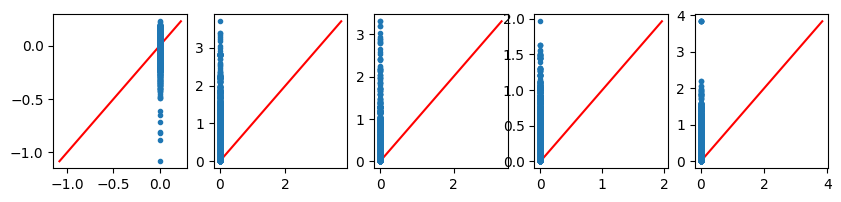

Epoch: 66, edge loss: 0.0000, node loss: 0.0007 0.0001 0.0001 0.0002


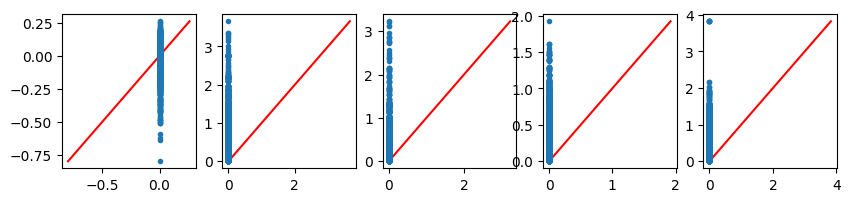

Epoch: 67, edge loss: 0.0000, node loss: 0.0007 0.0001 0.0001 0.0002


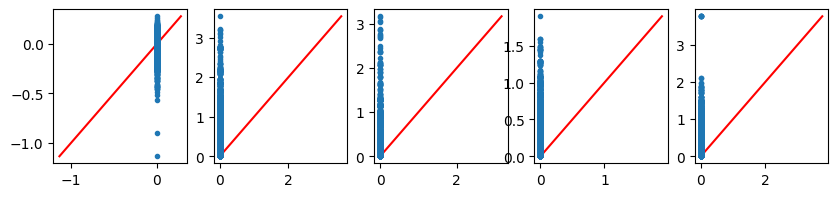

Epoch: 68, edge loss: 0.0000, node loss: 0.0007 0.0001 0.0001 0.0002


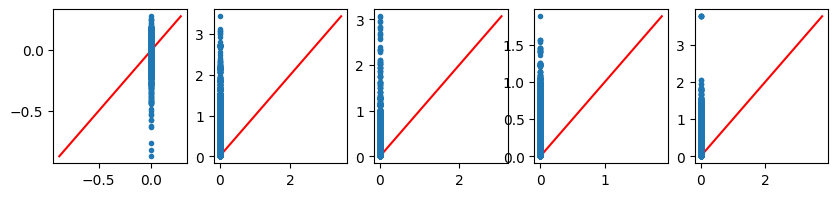

Epoch: 69, edge loss: 0.0000, node loss: 0.0006 0.0001 0.0001 0.0002


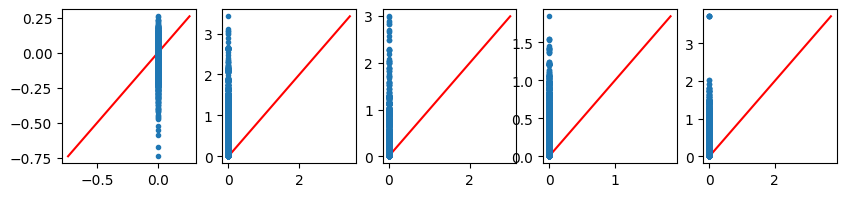

Epoch: 70, edge loss: 0.0000, node loss: 0.0006 0.0001 0.0001 0.0002


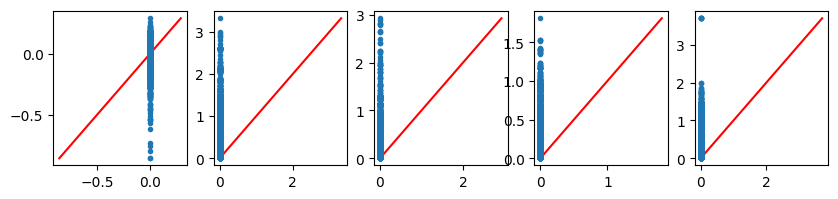

Epoch: 71, edge loss: 0.0000, node loss: 0.0007 0.0001 0.0001 0.0001


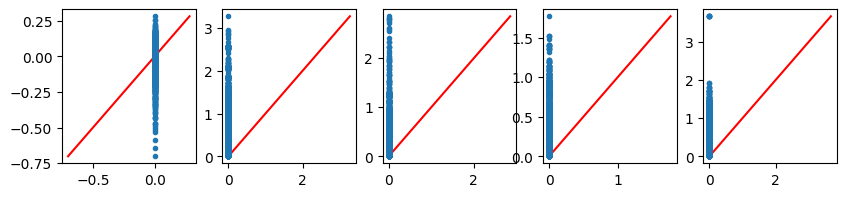

Epoch: 72, edge loss: 0.0000, node loss: 0.0006 0.0001 0.0001 0.0001


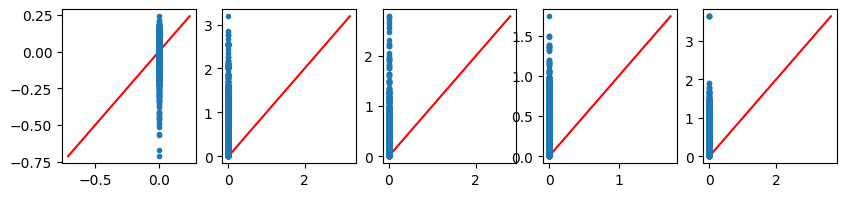

Epoch: 73, edge loss: 0.0000, node loss: 0.0006 0.0001 0.0001 0.0001


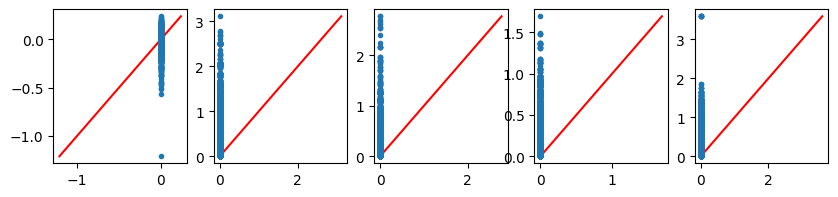

Epoch: 74, edge loss: 0.0000, node loss: 0.0006 0.0001 0.0001 0.0001


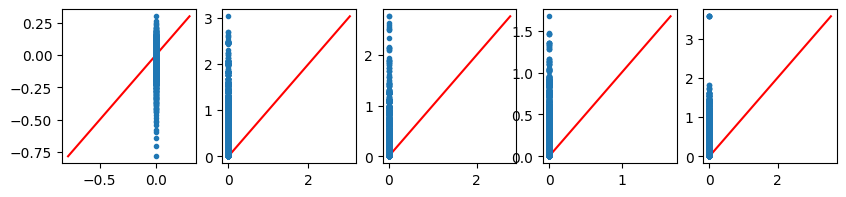

Epoch: 75, edge loss: 0.0000, node loss: 0.0006 0.0001 0.0001 0.0001


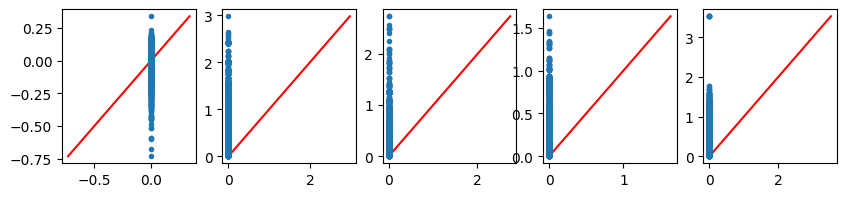

Epoch: 76, edge loss: 0.0000, node loss: 0.0005 0.0001 0.0001 0.0001


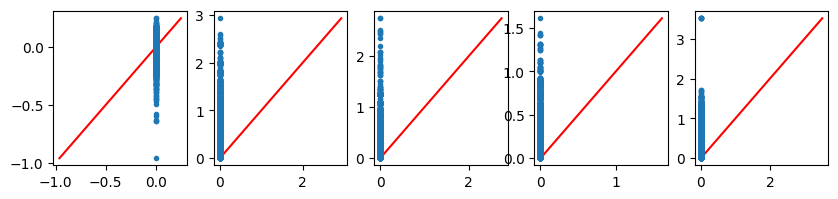

Epoch: 77, edge loss: 0.0000, node loss: 0.0005 0.0001 0.0001 0.0001


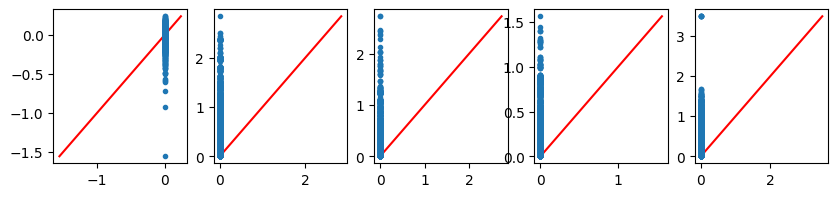

Epoch: 78, edge loss: 0.0000, node loss: 0.0005 0.0001 0.0001 0.0001


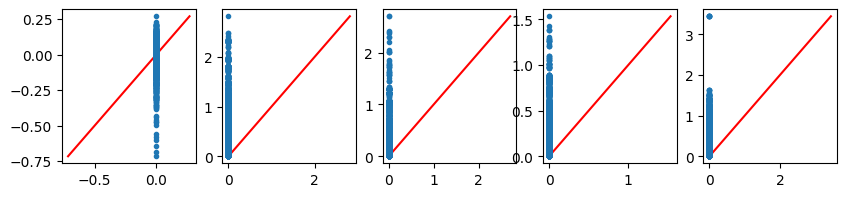

Epoch: 79, edge loss: 0.0000, node loss: 0.0005 0.0001 0.0001 0.0001


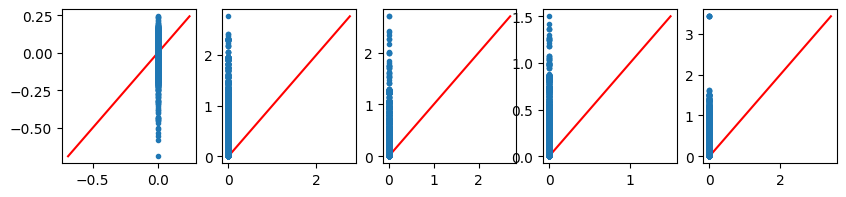

Epoch: 80, edge loss: 0.0000, node loss: 0.0005 0.0001 0.0001 0.0001


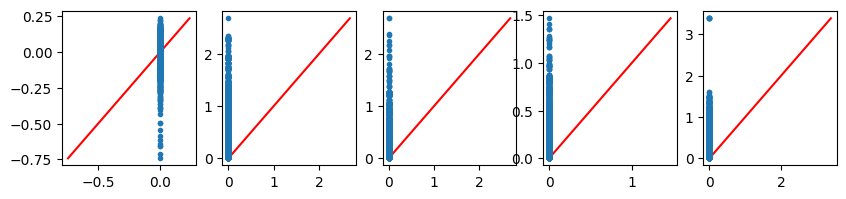

Epoch: 81, edge loss: 0.0000, node loss: 0.0005 0.0001 0.0001 0.0001


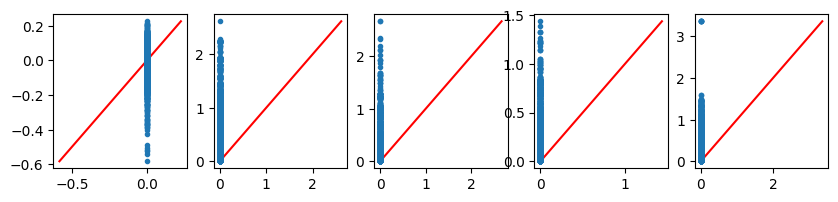

Epoch: 82, edge loss: 0.0000, node loss: 0.0005 0.0001 0.0001 0.0001


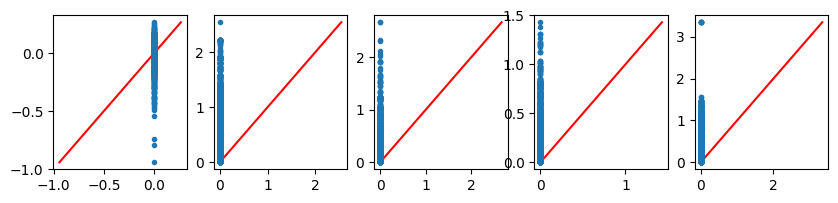

Epoch: 83, edge loss: 0.0000, node loss: 0.0004 0.0001 0.0001 0.0001


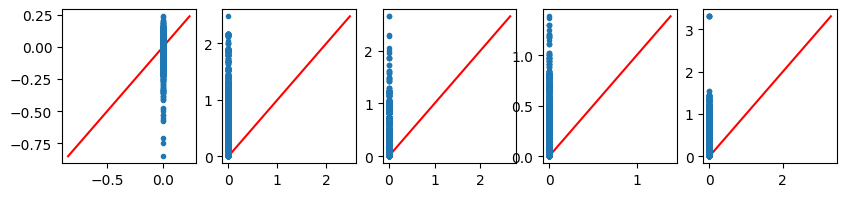

Epoch: 84, edge loss: 0.0000, node loss: 0.0004 0.0001 0.0001 0.0001


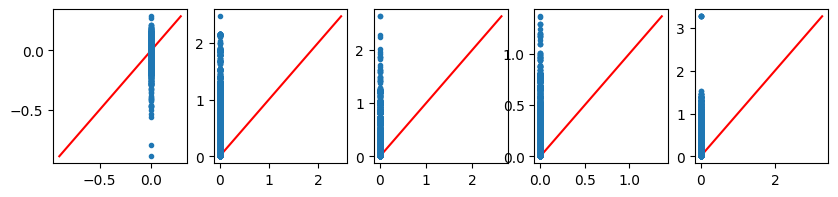

Epoch: 85, edge loss: 0.0000, node loss: 0.0004 0.0001 0.0001 0.0001


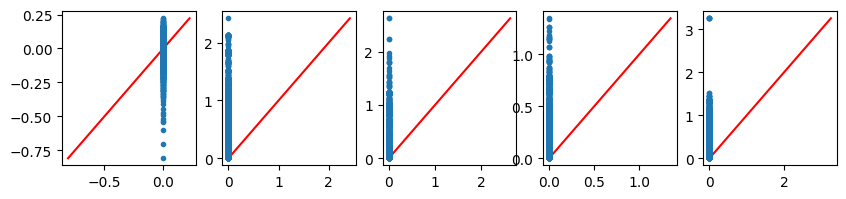

Epoch: 86, edge loss: 0.0000, node loss: 0.0004 0.0001 0.0001 0.0001


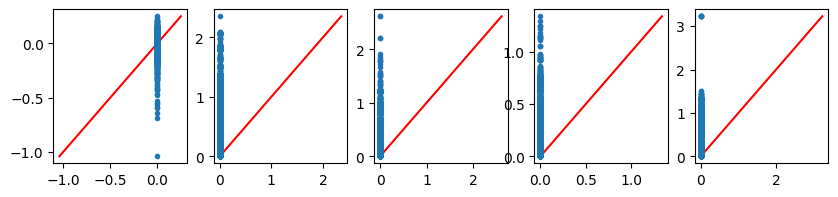

Epoch: 87, edge loss: 0.0000, node loss: 0.0004 0.0001 0.0000 0.0001


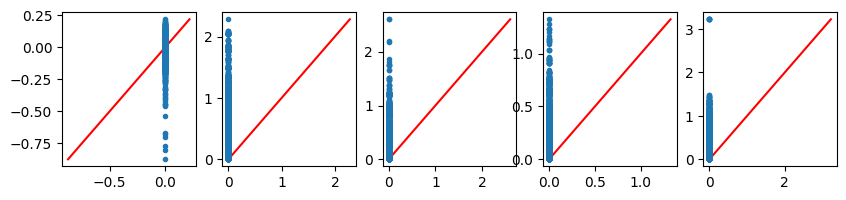

Epoch: 88, edge loss: 0.0000, node loss: 0.0004 0.0001 0.0001 0.0001


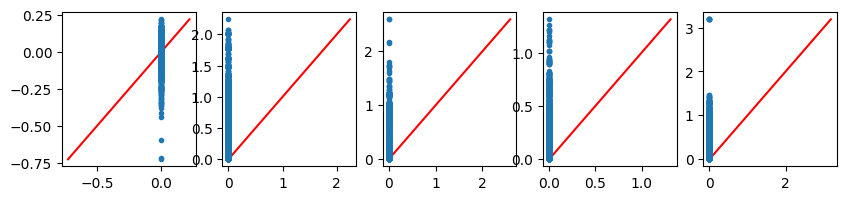

Epoch: 89, edge loss: 0.0000, node loss: 0.0004 0.0001 0.0000 0.0001


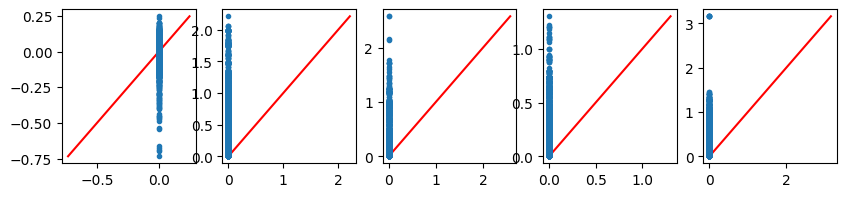

Epoch: 90, edge loss: 0.0000, node loss: 0.0004 0.0001 0.0000 0.0001


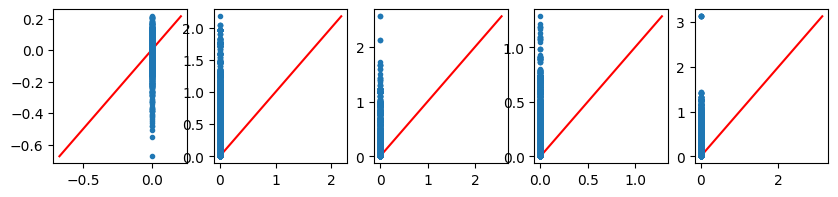

Epoch: 91, edge loss: 0.0000, node loss: 0.0004 0.0001 0.0000 0.0001


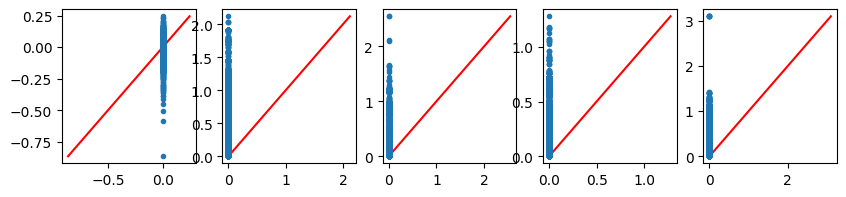

Epoch: 92, edge loss: 0.0000, node loss: 0.0003 0.0001 0.0000 0.0001


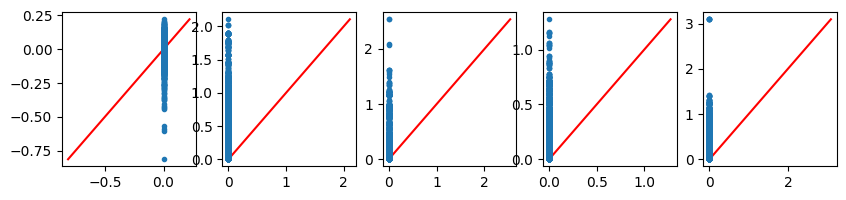

Epoch: 93, edge loss: 0.0000, node loss: 0.0003 0.0001 0.0000 0.0001


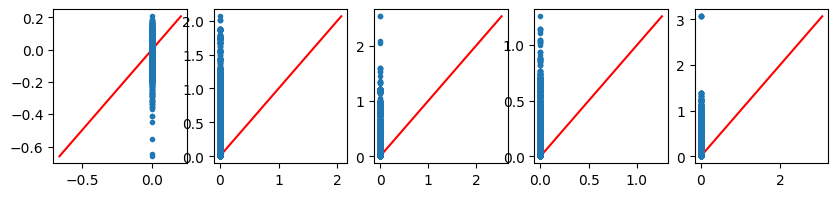

Epoch: 94, edge loss: 0.0000, node loss: 0.0003 0.0001 0.0000 0.0001


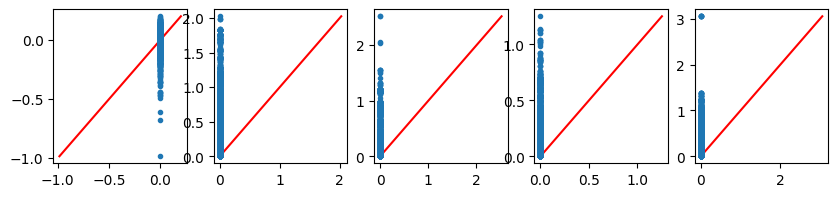

Epoch: 95, edge loss: 0.0000, node loss: 0.0003 0.0001 0.0000 0.0001


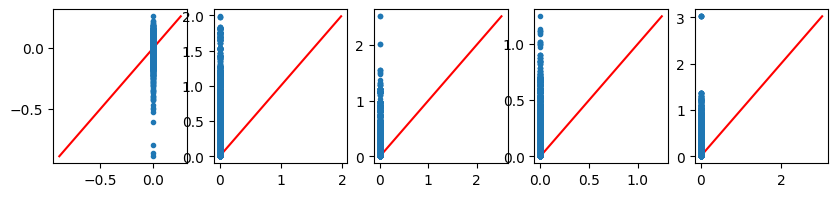

Epoch: 96, edge loss: 0.0000, node loss: 0.0003 0.0001 0.0000 0.0001


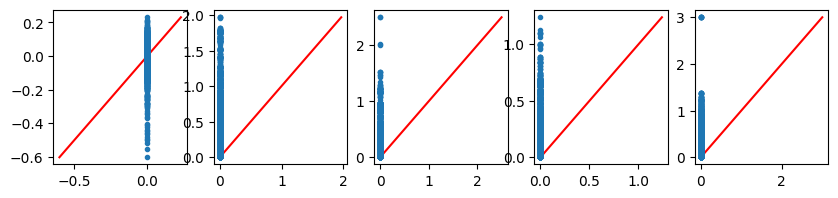

Epoch: 97, edge loss: 0.0000, node loss: 0.0003 0.0001 0.0000 0.0001


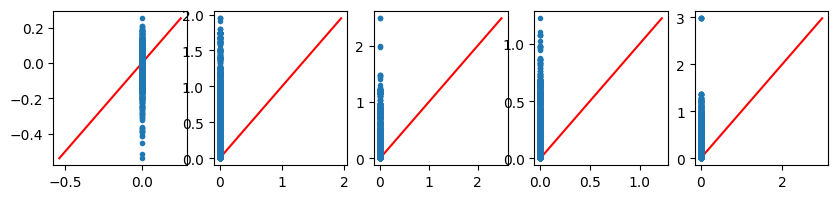

Epoch: 98, edge loss: 0.0000, node loss: 0.0003 0.0001 0.0000 0.0001


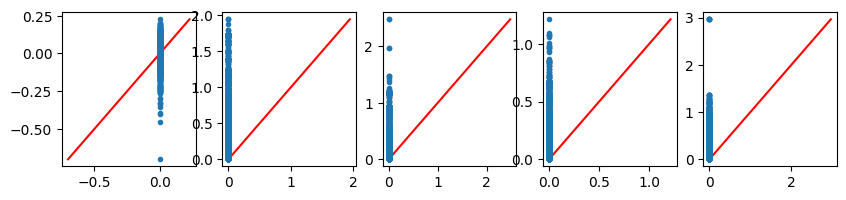

Epoch: 99, edge loss: 0.0000, node loss: 0.0003 0.0001 0.0000 0.0001


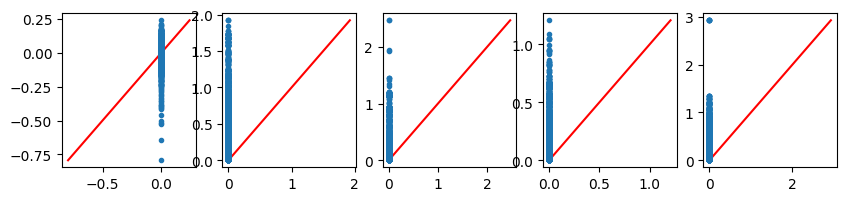

Epoch: 100, edge loss: 0.0000, node loss: 0.0003 0.0001 0.0000 0.0001


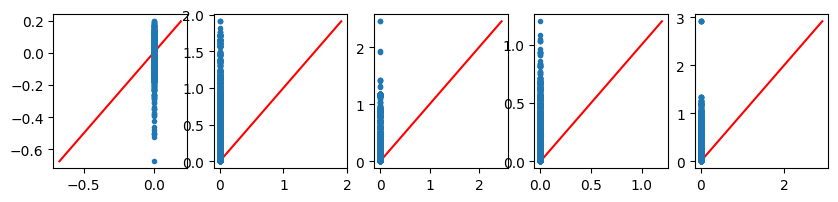

Epoch: 101, edge loss: 0.0000, node loss: 0.0003 0.0001 0.0000 0.0001


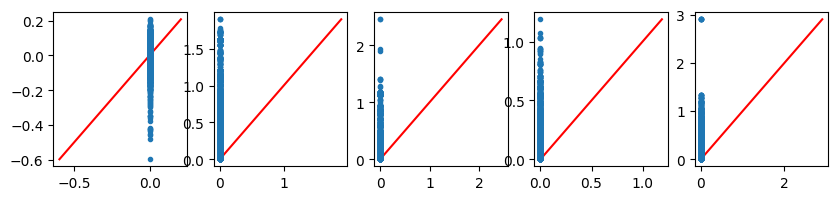

Epoch: 102, edge loss: 0.0000, node loss: 0.0003 0.0001 0.0000 0.0001


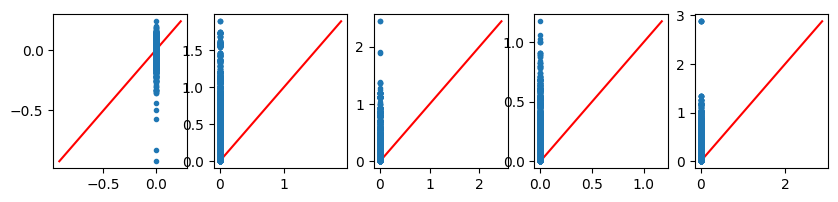

Epoch: 103, edge loss: 0.0000, node loss: 0.0003 0.0001 0.0000 0.0001


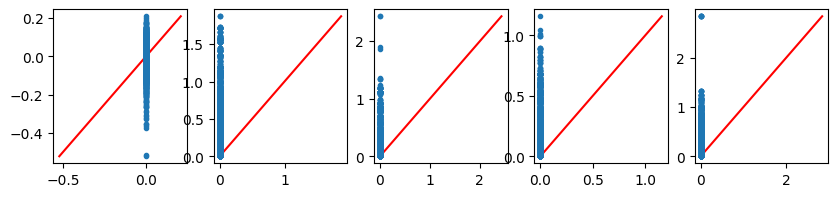

Epoch: 104, edge loss: 0.0000, node loss: 0.0003 0.0001 0.0000 0.0001


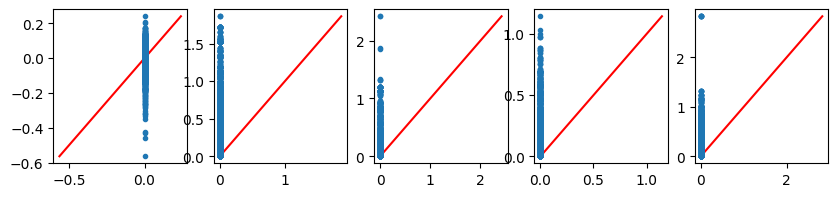

Epoch: 105, edge loss: 0.0000, node loss: 0.0002 0.0000 0.0000 0.0001


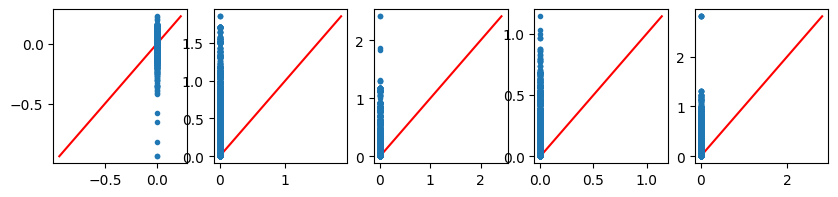

Epoch: 106, edge loss: 0.0000, node loss: 0.0002 0.0001 0.0000 0.0001


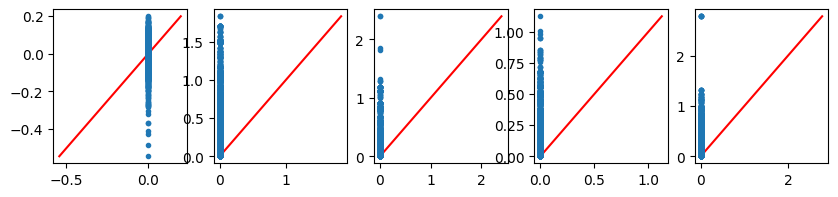

Epoch: 107, edge loss: 0.0000, node loss: 0.0002 0.0000 0.0000 0.0001


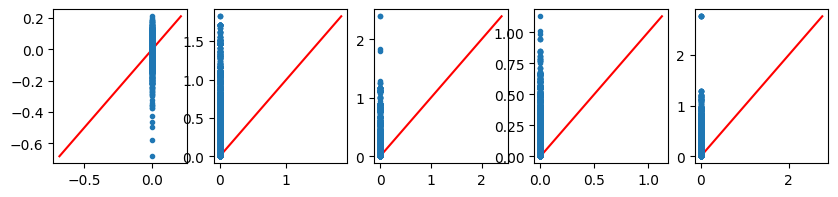

Epoch: 108, edge loss: 0.0000, node loss: 0.0002 0.0001 0.0000 0.0001


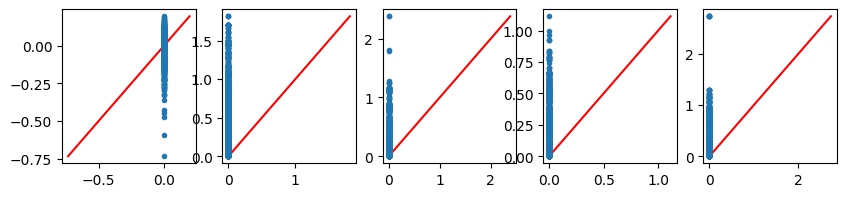

Epoch: 109, edge loss: 0.0000, node loss: 0.0002 0.0000 0.0000 0.0000


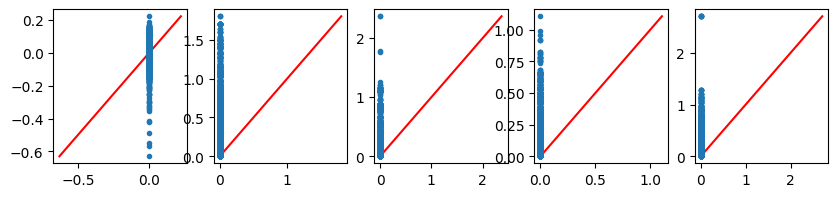

Epoch: 110, edge loss: 0.0000, node loss: 0.0002 0.0000 0.0000 0.0000


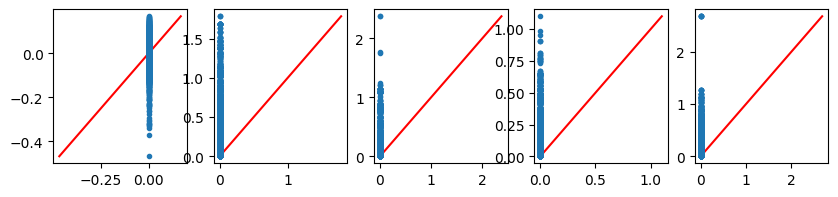

Epoch: 111, edge loss: 0.0000, node loss: 0.0002 0.0000 0.0000 0.0000


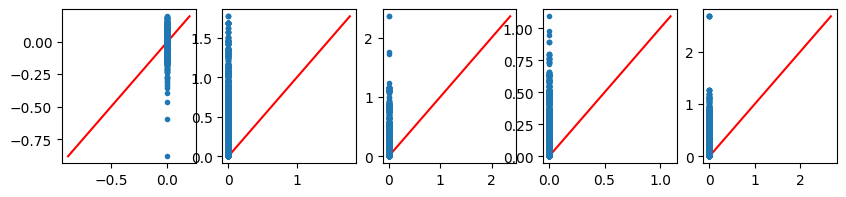

Epoch: 112, edge loss: 0.0000, node loss: 0.0002 0.0000 0.0000 0.0000


KeyboardInterrupt: 

In [13]:
# Initialize the optimizers
node_optimizer = torch.optim.Adam(node_model.parameters(), lr=learning_rate)
edge_optimizer = torch.optim.Adam(edge_model.parameters(), lr=learning_rate)

# Initialize early stopping
node_early_stopping = EarlyStopping(patience=patience, delta=delta, model_name=node_model_name)
edge_early_stopping = EarlyStopping(patience=patience, delta=delta, model_name=edge_model_name)

# Training loop
edge_train_losses = []
node_train_losses = []
for epoch in range(n_epochs):
    # Initialize train loss variable
    edge_loss_cum = 0
    node_loss_cum = np.zeros(n_node_features, dtype=float)
    ground_truth = {
        'edge_attr':         [],
        'atomic_mass':       [],
        'charge':            [],
        'electronegativity': [],
        'ionization_energy': []
    }
    prediction = {
        'edge_attr':         [],
        'atomic_mass':       [],
        'charge':            [],
        'electronegativity': [],
        'ionization_energy': []
    }
    for batch_0 in train_loader:
        #print()
        # Clone batch of graphs
        g_batch_0 = batch_0.clone()
        
        # Move batch data to GPU
        g_batch_0 = g_batch_0.to(device)
        
        # Read number of graphs in batch
        batch_size_0 = g_batch_0.num_graphs

        # Save graph-level embeddings
        embedding_batch_0 = []
        for idx in range(batch_size_0):
            embedding_batch_0.append(g_batch_0[idx].y.detach().to(device))
        
        # Initialize the gradient of the optimizers
        node_optimizer.zero_grad()
        edge_optimizer.zero_grad()
        
        # Start denoising-diffusing process
        t_steps = np.arange(1, n_t_steps+1)
        #ground_truth = []
        #prediction   = []
        #for t_step in t_steps:
        for t_step in [n_t_steps]:
            #ground_truth = []
            #prediction   = []
            
            # Read time step, which is added to node-level graph embeddings
            t_step_std = torch.tensor([t_step / n_t_steps - 0.5], dtype=torch.float).to(device)  # Standard normalization
        
            # Diffuse the graph with some noise
            #print()
            #print(f'Step: {t_step}')
            #print('Diffusing...')
            
            g_batch_t = []
            e_batch_t = []
            for idx in range(batch_size_0):
                # Perform a diffusion step at time step t_step for each graph within the batch
                graph_t, epsilon_t = diffusion_step(g_batch_0[idx], t_step, n_t_steps, alpha_decay)
                
                # Append noisy graphs and noises
                g_batch_t.append(graph_t)
                e_batch_t.append(epsilon_t)
        
                # Update diffused graph as next one
                g_batch_0[idx] = graph_t.clone()
            
            # Denoise the diffused graph
            #print(f'Denoising...')
            
            # Add embeddings to noisy graphs (t_step information and graph-level embeddings)
            for idx in range(batch_size_0):
                # Add graph-level embedding to graph_t as node embeddings
                g_batch_t[idx] = add_features_to_graph(g_batch_t[idx],
                                                       embedding_batch_0[idx])  # To match graph.y shape
                
                # Add t_step information to graph_t as node embeddings
                g_batch_t[idx] = add_features_to_graph(g_batch_t[idx],
                                                       t_step_std)  # To match graph.y shape, which is 1D
            
            # Generate batch objects
            g_batch_t = Batch.from_data_list(g_batch_t)
            e_batch_t = Batch.from_data_list(e_batch_t)
            
            # Move data to device
            g_batch_t = g_batch_t.to(device)
            e_batch_t = e_batch_t.to(device)
            
            # Predict batch noise at given time step
            pred_epsilon_t = predict_noise(g_batch_t, node_model, edge_model)

            # Get amount of noise that is added
            alpha_t              = get_alpha_t(t_step, n_t_steps, alpha_decay)
            e_batch_t.x         *= torch.sqrt(1 - alpha_t)
            e_batch_t.edge_attr *= torch.sqrt(1 - alpha_t)
            
            ground_truth['edge_attr'].append(e_batch_t.edge_attr.detach().cpu().numpy().tolist())
            ground_truth['atomic_mass'].append(e_batch_t.x[:, 0].detach().cpu().numpy().tolist())
            ground_truth['charge'].append(e_batch_t.x[:, 1].detach().cpu().numpy().tolist())
            ground_truth['electronegativity'].append(e_batch_t.x[:, 2].detach().cpu().numpy().tolist())
            ground_truth['ionization_energy'].append(e_batch_t.x[:, 3].detach().cpu().numpy().tolist())

            prediction['edge_attr'].append(pred_epsilon_t.edge_attr.detach().cpu().numpy().tolist())
            prediction['atomic_mass'].append(pred_epsilon_t.x[:, 0].detach().cpu().numpy().tolist())
            prediction['charge'].append(pred_epsilon_t.x[:, 1].detach().cpu().numpy().tolist())
            prediction['electronegativity'].append(pred_epsilon_t.x[:, 2].detach().cpu().numpy().tolist())
            prediction['ionization_energy'].append(pred_epsilon_t.x[:, 3].detach().cpu().numpy().tolist())
            
            # Backpropagation and optimization step
            #print('Backpropagating...')

            # Calculate the losses for node features and edge attributes
            node_losses, edge_loss = get_graph_losses(e_batch_t, pred_epsilon_t, batch_size_0)
            for i in range(len(node_losses)):
                node_losses[i] *= 100
            edge_loss *= 100
            
            # Combine losses for each attribute tensors
            node_loss = torch.stack(node_losses).sum()
            
            # Backpropagate and optimize node loss
            if not node_early_stopping.early_stop:
                node_loss.backward(retain_graph=True)
                node_optimizer.step()

            # Backpropagate and optimize edge loss
            if not edge_early_stopping.early_stop:
                edge_loss.backward(retain_graph=True)
                edge_optimizer.step()
            
            # Get items
            node_loss_cum += np.array([node_loss.item() for node_loss in node_losses])
            edge_loss_cum += edge_loss.item()
    
    fig, ax = plt.subplots(1, 5, figsize=(10, 2))
    for idx, item in enumerate(ground_truth):
        ground_truth_item = np.concatenate(ground_truth[item])
        prediction_item   = np.concatenate(prediction[item])
        
        stack = np.concatenate([ground_truth_item, prediction_item])
        
        _min_ = np.min(stack)
        _max_ = np.max(stack)
    
        ax[idx].plot([_min_, _max_], [_min_, _max_], '-r')
        ax[idx].plot(ground_truth_item, prediction_item, '.')
    plt.show()
    
    # Compute the average train loss over n_t_steps
    node_loss_cum /= (n_t_steps * len(train_loader))
    edge_loss_cum /= (n_t_steps * len(train_loader))
    
    # Append average losses
    node_train_losses.append(node_loss_cum)
    edge_train_losses.append(edge_loss_cum)
    
    # Check early stopping criteria
    node_early_stopping(node_loss_cum.sum(), node_model)
    edge_early_stopping(edge_loss_cum,       edge_model)

    if node_early_stopping.early_stop and edge_early_stopping.early_stop:
        print('Early stopping')
        break
    
    print_node_loss = ' '.join([f'{node_loss:.4f}' for node_loss in node_loss_cum])
    print(f'Epoch: {epoch+1}, edge loss: {edge_loss_cum:.4f}, node loss: {print_node_loss}')

In [ ]:
rescaled_edge_train_losses = np.sqrt(edge_train_losses) * dataset_parameters['edge_std'].numpy() + dataset_parameters['edge_mean'].numpy()
rescaled_edge_train_losses

In [ ]:
node_train_losses = np.array(node_train_losses)
rescaled_node_loss_cum = np.sqrt(node_train_losses) * dataset_parameters['feat_std'].numpy() + dataset_parameters['feat_mean'].numpy()
rescaled_node_loss_cum

In [ ]:
plt.plot(np.log(edge_train_losses), label='Edge')
for i in range(n_node_features):
    plt.plot(np.log(np.array(node_train_losses)[:, i]), label=f'Node {i}')
plt.xlabel('Epoch')
plt.ylabel('Loss function')
plt.legend(loc='best')
plt.show()

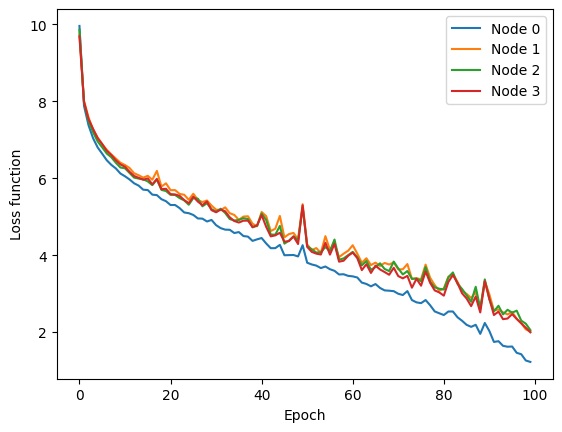

In [16]:
plt.show()
for i in range(n_node_features):
    plt.plot(np.log(np.array(node_train_losses)[:100, i]), label=f'Node {i}')
plt.xlabel('Epoch')
plt.ylabel('Loss function')
plt.legend(loc='best')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


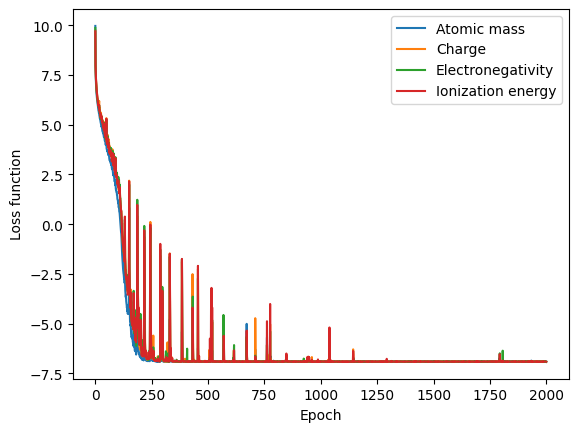

In [17]:
plt.plot(np.log(np.array(node_train_losses)[:, 0]), label=f'Atomic mass')
plt.plot(np.log(np.array(node_train_losses)[:, 1]), label=f'Charge')
plt.plot(np.log(np.array(node_train_losses)[:, 2]), label=f'Electronegativity')
plt.plot(np.log(np.array(node_train_losses)[:, 3]), label=f'Ionization energy')
plt.xlabel('Epoch')
plt.ylabel('Loss function')
plt.legend(loc='best')
plt.savefig('Losses.eps', dpi=50, bbox_inches='tight')
plt.show()

# Test of the model

In [18]:
# Training loop
edge_test_losses = 0
node_test_losses = np.zeros(n_node_features, dtype=float)
idx = 0
for batch_0 in test_loader:
    # Move batch data to GPU
    batch_0 = batch_0.to(device)
    
    # Read number of graphs in batch
    batch_size = batch_0.num_graphs
    
    # Diffuse batch
    g_batch_t = diffuse(batch_0, n_t_steps, s=alpha_decay)
    
    # Denoise batch
    g_batch_0 = denoise(g_batch_t, n_t_steps, node_model, edge_model, n_graph_features,
                        s=alpha_decay, sigma=sigma)
    
    # Calculate the loss for node features and edge attributes
    node_losses, edge_loss = get_graph_losses(batch_0, g_batch_0, batch_size)
    
    # Get items
    edge_loss_cum = edge_loss.item()
    node_loss_cum = np.array([node_loss.item() for node_loss in node_losses])
    
    # Append average losses
    edge_test_losses += edge_loss_cum
    node_test_losses += node_loss_cum
    
    print_node_loss = ' '.join([f'{node_loss:.4f}' for node_loss in node_loss_cum])
    print(f'Batch: {idx}, edge loss: {edge_loss_cum:.4f}, node loss: {print_node_loss}')
    idx += 1

Batch: 0, edge loss: 24.8465, node loss: 212.3832 213.9275 214.0108 214.2973
Batch: 1, edge loss: 25.0880, node loss: 212.2403 212.9170 212.2645 213.1144
Batch: 2, edge loss: 24.8986, node loss: 211.3064 212.6761 214.4718 211.8382
Batch: 3, edge loss: 25.2345, node loss: 211.5844 216.3691 213.3551 213.3280
Batch: 4, edge loss: 25.3257, node loss: 211.5093 212.6379 212.1174 215.4251
Batch: 5, edge loss: 25.1974, node loss: 212.1010 212.6580 210.9632 213.0612
Batch: 6, edge loss: 24.9891, node loss: 214.2816 212.6401 213.4441 213.5797
Batch: 7, edge loss: 25.0168, node loss: 212.2650 211.6600 211.1613 210.8414
Batch: 8, edge loss: 25.2655, node loss: 211.9940 212.9718 213.6581 214.7185
Batch: 9, edge loss: 24.6180, node loss: 213.0951 210.9494 211.3758 212.1215
Batch: 10, edge loss: 24.9792, node loss: 212.6557 213.0368 211.5230 212.8753
Batch: 11, edge loss: 25.0097, node loss: 212.8952 211.4136 213.3843 211.2797
Batch: 12, edge loss: 25.2093, node loss: 212.0372 211.8828 212.5175 213.8

In [19]:
node_test_losses /= len(test_loader)
edge_test_losses /= len(test_loader)

In [20]:
edge_test_losses, node_test_losses

(25.0446346282959,
 array([212.15519028, 212.11002426, 212.68504028, 212.8836586 ]))

# Save results

In [21]:
# Create and save as a dictionary
model_performance = {
    'edge_train_losses': edge_train_losses,
    'node_train_losses': np.array(node_train_losses).tolist(),
    'edge_test_losses':  edge_test_losses,
    'node_test_losses':  node_test_losses.tolist()
}

# Write the dictionary to the file in JSON format
with open(f'{target_folder}/model_performance.json', 'w') as json_file:
    json.dump(model_performance, json_file)